In [25]:
from sklearn.decomposition import NMF
from EM_SPADE import EMSPADE
from opt_einsum import contract
import scanpy as sc
import itertools
from scipy.stats import spearmanr
import numpy as np 
import seaborn as sns
import pandas as pd
from pyspade_global import *
import matplotlib.pyplot as plt
import netNMFsc
from sklearn.metrics import roc_curve, auc 

## shows how score_genes can fail when pathways overlap

- simulate 5 overlapping pathways and sparse loadings using create_pathways function
- run score genes

In [26]:
def simulate_base_data(N,k,p):
    theta_star = np.random.exponential(size = (p,k))
    theta_star[theta_star < 2] = 0 
    cov = np.eye(k) 
    lst = []
    for i in range(N):
        a = np.exp(np.random.multivariate_normal(np.zeros(k),cov))
        lst.append(a)
    A_star = np.array(lst)
    A_star[A_star < 1] = 0
    global_mean = contract('ik,jk->ij',A_star,theta_star)
    data = np.random.poisson(global_mean)
    return(data,A_star,theta_star)

def create_pathways(n_control_pathways,n_active_pathways, gene_set_size, p, N, overlap,signal_strength):
    ct = 0
    ct2 = 0
    base = np.zeros((n_active_pathways,p))
    lst = []
    gene_sets = []
    for i in range(n_active_pathways):
        base[ct2, ct:ct + gene_set_size] = np.random.exponential(scale = signal_strength, size = gene_set_size)
        gene_sets.append(list(range(ct,ct + gene_set_size)))
        ct = ct + int((1 - overlap)*gene_set_size)
        ct2 = ct2 + 1
    for i in range(n_control_pathways):
        gene_sets.append(list(range(ct,ct + gene_set_size)))
        ct = ct + int((1 - overlap)*gene_set_size)
        ct2 = ct2 + 1
        
    cov = np.eye(n_active_pathways) 
    lst = []
    for i in range(N):
        a = np.exp(np.random.multivariate_normal(np.zeros(n_active_pathways),cov))
        lst.append(a)
    A_star = np.array(lst)
    A_star[A_star < 1] = 0
    global_mean = contract('ik,kj->ij',A_star,base)
    data = np.random.poisson(global_mean)
    return data,base, A_star,gene_sets

def remove(lst,idx):
    lst_return = []
    for i in range(len(lst)):
        if i not in idx:
            lst_return.append(lst[i])
    return lst_return
def noisy_gene_sets(gene_sets,p,FNR,FPR):
    noisy = []
    q = len(gene_sets[0])
    for gene_set in gene_sets:
        
        to_drop = np.random.permutation(len(gene_set))[:int(FNR*q)]
        new_gene_set = remove(gene_set, to_drop)
        new_gene_set = new_gene_set + list(np.random.permutation(p)[:int(FPR*q)])
        noisy.append(new_gene_set)
    return noisy

In [27]:
data,base, A_star,gene_sets = create_pathways(0,10, 20, 200, 1000, 0.6,16)

In [28]:
data = data[:, data.sum(axis = 0) > 0]

In [29]:
p = data.shape[1]

In [30]:
adj_matrix = np.zeros((p,p))
for gene_set in gene_sets:
    for i in gene_set:
        for j in gene_set:
            if i!=j:
                adj_matrix[i,j] = 1

In [31]:
spade = EMSPADE(X= data, A = adj_matrix, K = 10, delta = 0.001, kappa = 0.00001,rho = 0.001,lam = 1.0/0.01, T = 10)

ct = 0
for gs in gene_sets:
    spade.theta[gs,ct] = 10
    ct = ct + 1
    

In [32]:
spade.fit(n_epochs = 200, suppress = False)

NLL:  -13336389.265
NLL:  -13681330.904
NLL:  -13857981.454
NLL:  -13987532.281
NLL:  -14091005.336
NLL:  -14173581.753
NLL:  -14237055.79
NLL:  -14283536.665
NLL:  -14316319.804
NLL:  -14338939.149
NLL:  -14354419.678
NLL:  -14365051.914
NLL:  -14372442.755
NLL:  -14377666.186
NLL:  -14381425.682
NLL:  -14384182.522
NLL:  -14386239.622
NLL:  -14387800.615
NLL:  -14389004.991
NLL:  -14389949.967
NLL:  -14390704.323
NLL:  -14391317.265
NLL:  -14391824.201
NLL:  -14392250.546
NLL:  -14392614.454
NLL:  -14392928.684
NLL:  -14393202.218
NLL:  -14393441.559
NLL:  -14393651.736
NLL:  -14393836.972
NLL:  -14394001.009
NLL:  -14394146.987
NLL:  -14394277.594
NLL:  -14394396.109
NLL:  -14394504.639
NLL:  -14394604.912
NLL:  -14394698.328
NLL:  -14394786.01
NLL:  -14394868.857
NLL:  -14394947.591
NLL:  -14395022.794
NLL:  -14395094.938
NLL:  -14395164.407
NLL:  -14395231.517
NLL:  -14395296.533
NLL:  -14395359.672
NLL:  -14395421.121
NLL:  -14395481.035
NLL:  -14395539.548
NLL:  -14395596.773
NL

In [33]:
adata = sc.AnnData(data)
adata.var_names =[str(i) for i in list(range(p))]

In [34]:
gene_sets[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [35]:
for j in range(10):
    sc.tl.score_genes(adata, gene_list = [str(i) for i in gene_sets[j]],score_name = str(j))

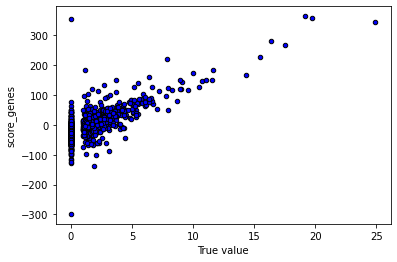

In [36]:
plt.scatter(A_star[:,0], adata.obs['0'], s= 20, c= "blue", edgecolors = "black")
plt.xlabel("True value")
plt.ylabel("score_genes")
plt.show()

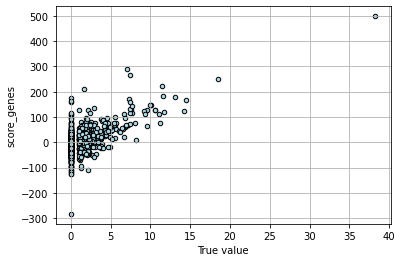

In [37]:
plt.scatter(A_star[:,1], adata.obs['1'], s= 20, c= "lightblue", edgecolors = "black")
plt.xlabel("True value")
plt.ylabel("score_genes")
plt.grid()
plt.show()

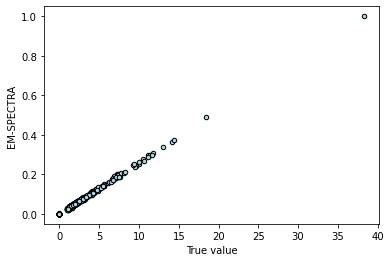

In [38]:
plt.scatter(A_star[:,1], spade.alpha[:,1]/spade.alpha[:,1].max(), s= 20, c= "lightblue", edgecolors = "black")
plt.xlabel("True value")
plt.ylabel("EM-SPECTRA")
plt.show()

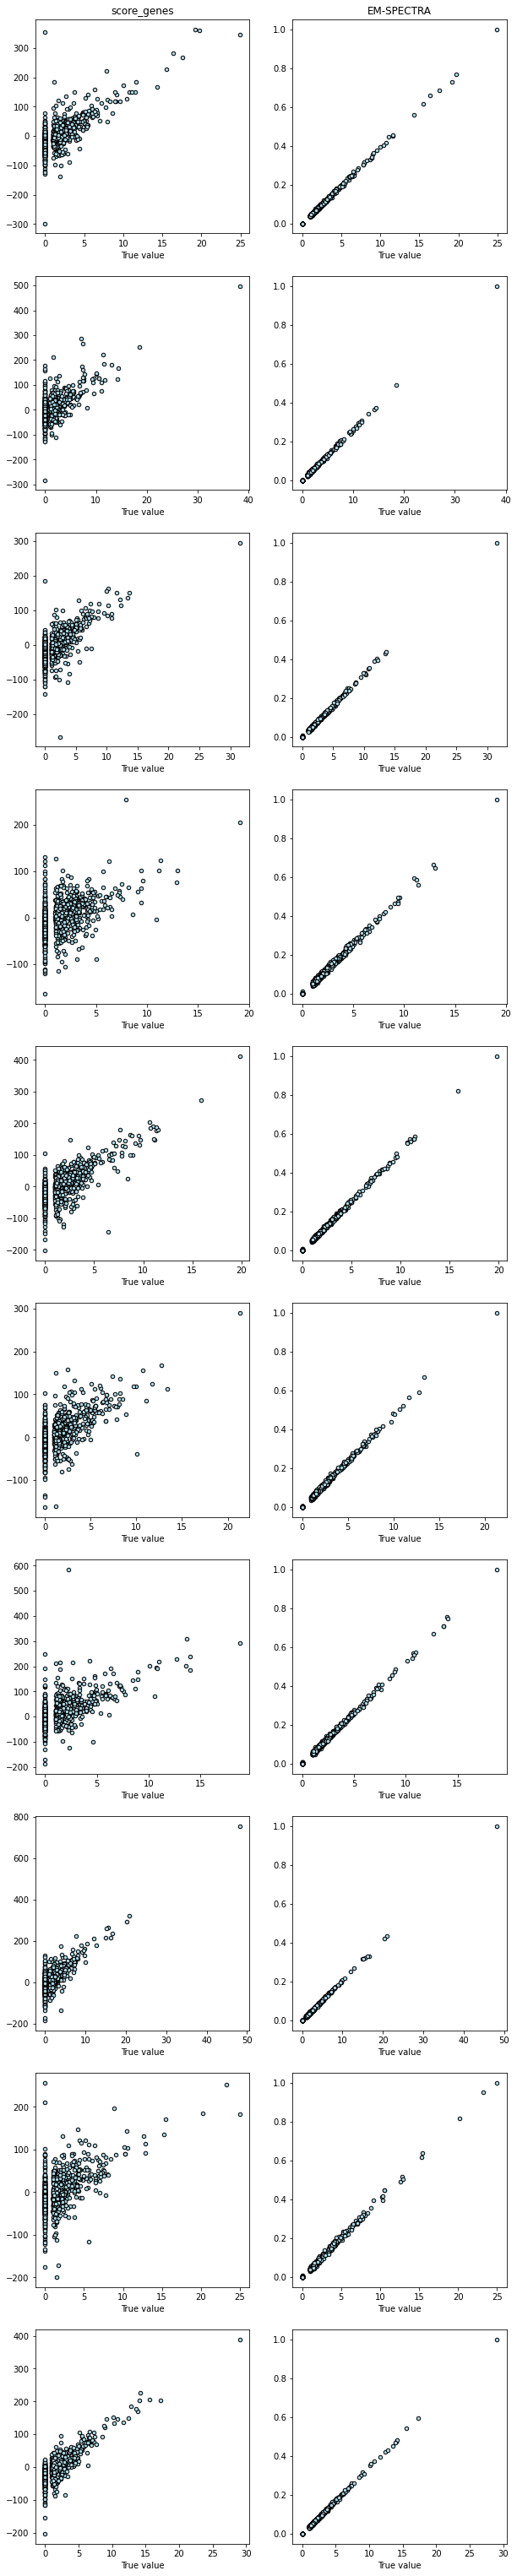

In [39]:
# Some example data to display

fig, axs = plt.subplots(10, 2, figsize=(10,55))
axs[0, 0].scatter(A_star[:,0], adata.obs['0'], s= 20, c= "lightblue", edgecolors = "black")
axs[0, 0].set_title('score_genes')
axs[0, 1].scatter(A_star[:,0], spade.alpha[:,0]/spade.alpha[:,0].max(), s= 20, c= "lightblue", edgecolors = "black")
axs[0, 1].set_title('EM-SPECTRA')

for i in range(1,10):
    axs[i, 0].scatter(A_star[:,i], adata.obs[str(i)], s= 20, c= "lightblue", edgecolors = "black")
    axs[i, 1].scatter(A_star[:,i], spade.alpha[:,i]/spade.alpha[:,i].max(), s= 20, c= "lightblue", edgecolors = "black")


for ax in axs.flat:
    ax.set(xlabel='True value')
plt.show()
#plt.savefig("simulations/score_genes_v_spade.png", dpi = 300)
# Hide x labels and tick labels for top plots and y ticks for right plots.

<AxesSubplot:>

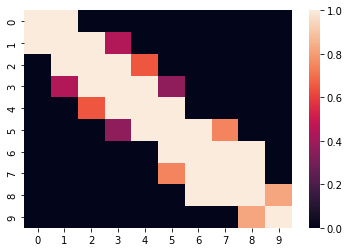

In [40]:
sns.heatmap(spade.B)
#plt.savefig("simulations/scoregenes_v_spade_B_matrix.png", dpi = 300)

## Quantification

In [41]:
overlaps = []
values = []
models = []
for overlap in [0.0,0.3,0.5,0.75]:
    for trial in range(3):
        data,base, A_star,gene_sets = create_pathways(0,10, 20, 500, 1000, overlap,16)
        data = data[:, data.sum(axis = 0) > 0]
        p = data.shape[1]
        adj_matrix = np.zeros((p,p))
        for gene_set in gene_sets:
            for i in gene_set:
                for j in gene_set:
                    if i!=j:
                        adj_matrix[i,j] = 1
        spade = EMSPADE(X= data, A = adj_matrix, K = 10, delta = 0.001, kappa = 0.00001,rho = 0.001,lam = 1.0/0.01, T = 10)
        ct = 0
        for gs in gene_sets:
            spade.theta[gs,ct] = 10
            ct = ct + 1
        spade.fit(n_epochs = 200, suppress = True)
        adata = sc.AnnData(data)
        adata.var_names =[str(i) for i in list(range(p))]
        for j in range(10):
            sc.tl.score_genes(adata, gene_list = [str(i) for i in gene_sets[j]],score_name = str(j))
        for i in range(10):    
            values.append(np.corrcoef(A_star[:,i], spade.alpha[:,i]/spade.alpha[:,i].max())[0,1])
            overlaps.append(overlap)
            models.append("spectra")
        for i in range(10):
            values.append(np.corrcoef(A_star[:,i], adata.obs[str(i)])[0,1])
            overlaps.append(overlap)
            models.append("score_genes")


In [44]:
df = pd.DataFrame()
df["model"] = models
df["pearson"] = values
df["overlap"] = overlaps

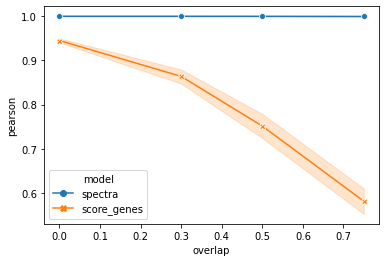

In [45]:
sns.lineplot(
    data=df,
    x="overlap", y="pearson", hue="model", style="model",
    markers=True, dashes=False
)
plt.show()

#plt.savefig("simulations/scoregenes_v_spectra_quant.svg", dpi = 300)